In [1]:
import numpy as np
from sklearn.datasets import make_classification, make_blobs
import matplotlib.pyplot as plt

## Данные

In [2]:
#X, y = make_classification(300, 2, n_informative=2, 
#                           n_redundant=0, n_classes=4, 
#                           n_clusters_per_class=1, random_state=5)

X, y = make_blobs(n_samples=200, centers=4, cluster_std=2.5, random_state=42)

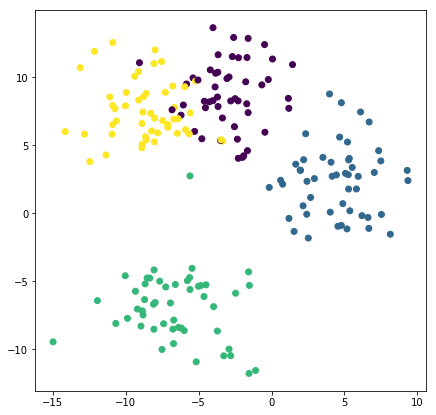

In [3]:
plt.figure(figsize=(7, 7))
plt.scatter(X[:, 0], X[:, 1], c=y);

## К-средних

Назначение кластера объектам, имея координаты центроидов:
$$ l_j = argmax_{i=1..k} |c_i - x_j|, \quad l_j \text{ - метка кластера, } c_i, x_j \in \mathbb{R}^n \text{ - i-й центроид и j-й объект}$$

Вычисление позиций центроидов кластеров, имея назначения объектов:

$$ c_i = \frac {1} {n_i} \sum_{j=1}^{n_i} x_j, \quad n_i \text{ - число объектов в i-ом кластере } $$

In [4]:
from sklearn.metrics.pairwise import euclidean_distances

class KMeans:        
    def train(self, X, k, init='random', track_history=False):
        self.iters_count = 0
        if init == 'random':
            self.centroids = X[np.random.choice(len(X), k)]
        elif init == 'kmeans++':
            self.init_kmeans_pp(X, k)
        else:
            raise ValueError('Wrong initialization type')
            
        if track_history:
            self.history = {'centroids': [self.centroids], 'clusters': []}
        has_converged = False
        
        while not has_converged:
            clusters_assignment = self.assign_clusters(X)
            new_centroids = self.move_centroids(X, k, clusters_assignment)
            has_converged = np.linalg.norm(new_centroids - self.centroids) < 1e-5
            self.centroids = new_centroids
            
            if track_history:
                self.history['centroids'].append(self.centroids)
                self.history['clusters'].append(clusters_assignment)
            self.iters_count += 1
            if self.iters_count > 100:
                break

        if track_history:
            print(f'Алгоритм сошелся за {self.iters_count} итераций')
        
    def evaluate(self, X):
        cluster_assignment = self.assign_clusters(X)
        numerator = 0
        denominator = 0
        for k in range(len(self.centroids)):
            cluster = X[cluster_assignment == k]
            if len(cluster) < 2:
                continue
            numerator += np.sum(euclidean_distances(cluster)) / 2
            denominator += (len(cluster) * (len(cluster) - 1)) / 2

        return numerator / denominator
    
    def init_kmeans_pp(self, X, k):
        self.centroids = [X[np.random.randint(0, len(X) - 1)]]
        for i in range(1, k):
            dist = np.array([np.linalg.norm(self.centroids - x, axis=1).min() for x in X])
            dist /= dist.sum()
            random_index = np.random.choice(range(len(X)), 1, p=dist)[0]
            self.centroids.append(X[random_index])
    
    def assign_clusters(self, X):
        return np.array([
            np.argmin(np.linalg.norm(x - self.centroids, axis=1)) for x in X
        ])
    
    def move_centroids(self, X, k, clusters_assignment):
        new_centroids = np.zeros_like(self.centroids)
        
        for i in range(k):
            cluster = X[clusters_assignment == i]
            if not len(cluster):
                continue
            new_centroids[i] = np.mean(X[clusters_assignment == i], axis=0)

        return new_centroids

## Подбор числа кластеров

Алгоритм сошелся за 3 итераций
Алгоритм сошелся за 8 итераций
Алгоритм сошелся за 9 итераций
Алгоритм сошелся за 7 итераций
Алгоритм сошелся за 12 итераций


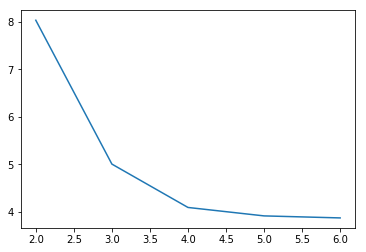

In [5]:
kmeans = KMeans()
scores = []
for k in range(2, 7):
    kmeans.train(X, k, track_history=True)
    scores.append(kmeans.evaluate(X))
plt.plot(range(2, 7), scores);

## График итераций

### Случайная инициализация

In [9]:
kmeans = KMeans()
cluster_number = 4
kmeans.train(X, cluster_number, track_history=True)
predicted_clusters = kmeans.assign_clusters(X)
print(f'Среднее внутрекластерное расстояние:  {kmeans.evaluate(X)}')

Алгоритм сошелся за 8 итераций
Среднее внутрекластерное расстояние:  4.095437549471957


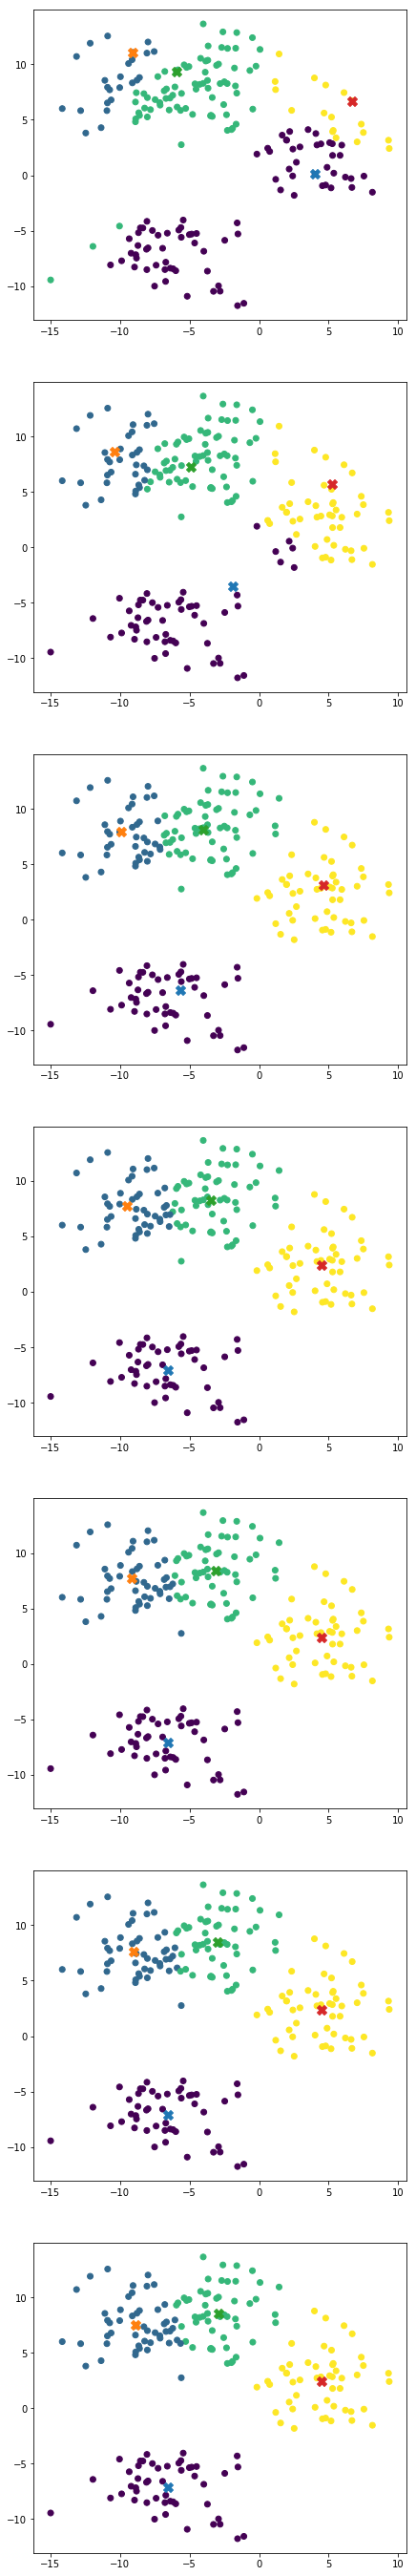

In [10]:
fig, axs = plt.subplots(kmeans.iters_count - 1)
fig.set_figheight(7 * (kmeans.iters_count - 1))
fig.set_figwidth(7)

for i in range(kmeans.iters_count - 1):
    axs[i].scatter(X[:, 0], X[:, 1], c=kmeans.history['clusters'][i])
    for k in range(cluster_number):
        axs[i].scatter([kmeans.history['centroids'][i][k][0]],
                       [kmeans.history['centroids'][i][k][1]],
                       s=100,
                       marker='X')

### kmeans++

In [13]:
kmeans = KMeans()
cluster_number = 4
kmeans.train(X, cluster_number, init='kmeans++', track_history=True)
predicted_clusters = kmeans.assign_clusters(X)
print(f'Среднее внутрекластерное расстояние:  {kmeans.evaluate(X)}')

Алгоритм сошелся за 4 итераций
Среднее внутрекластерное расстояние:  4.095437549471957


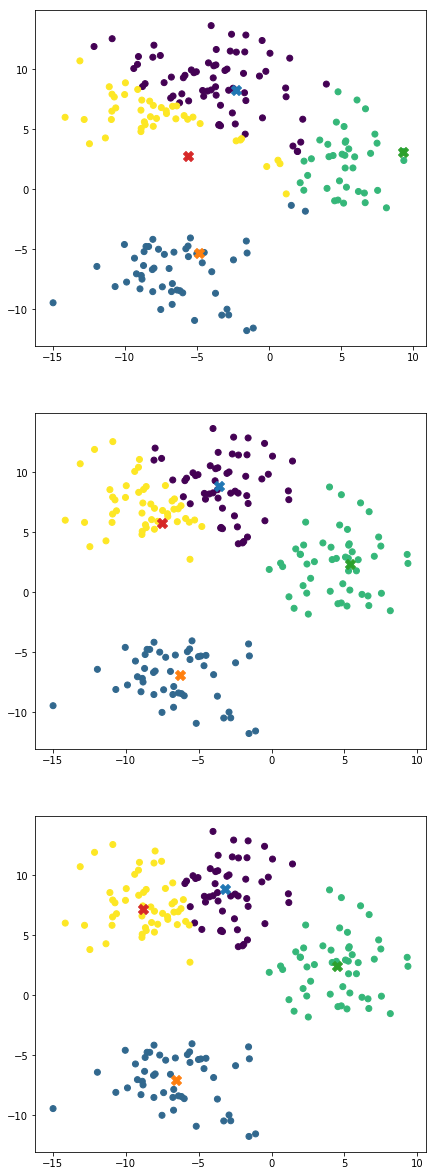

In [14]:
fig, axs = plt.subplots(kmeans.iters_count - 1)
fig.set_figheight(7 * (kmeans.iters_count - 1))
fig.set_figwidth(7)

for i in range(kmeans.iters_count - 1):
    axs[i].scatter(X[:, 0], X[:, 1], c=kmeans.history['clusters'][i])
    for k in range(cluster_number):
        axs[i].scatter([kmeans.history['centroids'][i][k][0]],
                       [kmeans.history['centroids'][i][k][1]],
                       s=100,
                       marker='X')

## Среднее число итераций

In [46]:
import tqdm

In [47]:
random_states = np.random.choice(range(10000), 200)
kmeans = KMeans()

In [48]:
%%time
iters_rand = []
scores_rand = []
for rs in tqdm.tqdm(random_states):
    X, y = make_blobs(n_samples=200, centers=5, cluster_std=2.5, random_state=rs)
    kmeans.train(X, 5, init='random', track_history=False)
    iters_rand.append(kmeans.iters_count)
    scores_rand.append(kmeans.evaluate(X))

100%|██████████| 200/200 [00:06<00:00, 31.54it/s]

CPU times: user 14.7 s, sys: 1.72 s, total: 16.4 s
Wall time: 6.34 s


In [49]:
%%time
iters_pp = []
scores_pp = []
for rs in tqdm.tqdm(random_states):
    X, y = make_blobs(n_samples=200, centers=5, cluster_std=2.5, random_state=rs)
    kmeans.train(X, 5, init='kmeans++', track_history=False)
    iters_pp.append(kmeans.iters_count)
    scores_pp.append(kmeans.evaluate(X))

100%|██████████| 200/200 [00:08<00:00, 23.45it/s]

CPU times: user 18.5 s, sys: 1.88 s, total: 20.4 s
Wall time: 8.53 s


In [50]:
print(f'Среденее число итераций при случайной ининиализации: {sum(iters_rand) / len(iters_rand)}')
print(f'Среденее число итераций при kmeans++ ининиализации: {sum(iters_pp) / len(iters_pp)}')

Среденее число итераций при случайной ининиализации: 10.94
Среденее число итераций при kmeans++ ининиализации: 10.36


In [52]:
print(f'Среденее внутрикластерное расстояние при случайной ининиализации: {round(sum(scores_rand) / len(scores_rand), 2)}')
print(f'Среденее внутрикластерное расстояние при kmeans++ ининиализации: {round(sum(scores_pp) / len(scores_pp), 2)}')

Среденее внутрикластерное расстояние при случайной ининиализации: 3.97
Среденее внутрикластерное расстояние при kmeans++ ининиализации: 3.89


### Пример с цифрами

In [53]:
from sklearn.datasets import load_digits
from sklearn.decomposition import PCA

In [64]:
data = load_digits()

X = data['data']
X = X[:, X.std(axis=0) != 0]  # drop columns with constant value
X /= 255  # normalize

y = data['target']

In [65]:
kmeans = KMeans()
scores = []
for k in tqdm.tqdm(range(3, 15)):
    kmeans.train(X, k, track_history=False)
    scores.append(kmeans.evaluate(X))

100%|██████████| 12/12 [00:05<00:00,  2.31it/s]


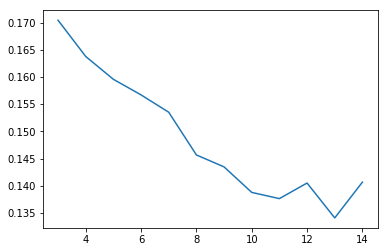

In [66]:
plt.plot(range(3, 15), scores);

In [71]:
kmeans = KMeans()
cluster_number = 10
kmeans.train(X, cluster_number, init='kmeans++', track_history=True)
predicted_clusters = kmeans.assign_clusters(X)
print(f'Среднее внутрикластерное расстояние:  {kmeans.evaluate(X)}')

Алгоритм сошелся за 17 итераций
Среднее внутрикластерное расстояние:  0.1382283905041359


In [72]:
prediction = kmeans.assign_clusters(X)

In [73]:
X_2d = PCA(n_components=2).fit_transform(X)

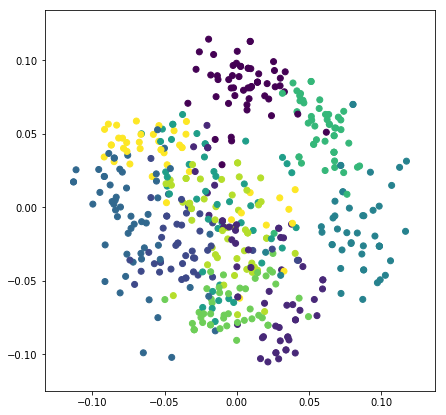

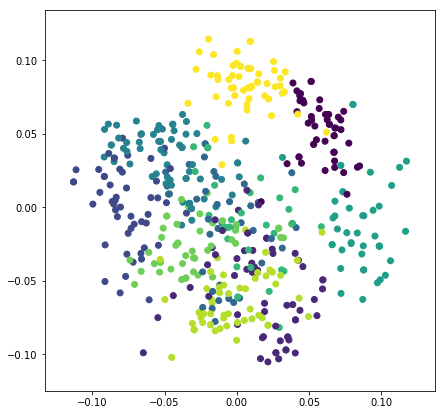

In [74]:
inds = np.random.choice(range(len(X)), 500)

plt.figure(figsize=(7, 7))
plt.scatter(X_2d[inds,0], X_2d[inds,1], c=y[inds])
plt.figure(figsize=(7, 7))
plt.scatter(X_2d[inds,0], X_2d[inds,1], c=prediction[inds]);